## TALLER 2

Para solucionar la tarea, primero se importaron las funciones requeridas par la solución del taller

In [2]:
%pylab inline
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Luego, se declaron los parametros del kart encontrados en los documentos de clavijo y cordoba, como los radios de las llantas, la relación de transmición, las inercias, dimensiones y masa del kart.

In [3]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)


#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)
mr=((2*illd+2*illt+ig)+ii*(ng**2))/(refc**2)


# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

Después, se implementaron funciones para cada una de las variables dependientes de la velocidad en el modelo de aceleración a solucionar, teniendo en cuanta que el modelo es:

$(M+M_r)a_x = \frac{T_e N_c \eta_t}{r} - R_x - D_A$  


- Fuerza de resustecia a la rodadura:

$R_x = R_{xf} + R_{xr} = f_r(W_f+W_r) = f_rW\ $ 

Donde:

$f_r=0.01(1+\frac{v_x}{100})$

In [4]:
def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)

    return w*fr # (N)

- Fuerza de arrastre aerodinámico: 

$D_A = \frac{1}{2}\rho A_f C_d v_x^2$

In [5]:
def farrastre(vx):      
    
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

- Torque del motor: 

$T_e= \frac{Potencia}{\omega [rad/s^2] ^{2}}$

Donde:

$Potencia = 3.037((-0.00000004564538677\omega[rpm]^3)+(0.0001056995459\omega[rpm]^2)+(1.53209191\omega[rpm])-1.895523696)$

Para limitar la velocidad angular fue necesario tener en cuenta que la máxima velocidad angular que entrega el motor la cual es de 5000 rpm, también es necesario condicionar el torque que entrega el motor para obetener resultados aceptables.

In [6]:
def torquemotor(vx,ng_1):
    
    vel_angular=((vx*ng_1)/refc)*(60/(2*pi))
        
    if vel_angular > 5000:
            
        vel_angular=5000

    P=3.037*((-0.00000004564538677*vel_angular**3)+(0.0001056995459*vel_angular**2)+(1.53209191*vel_angular)-1.895523696)
    T=P/(vel_angular*(2*pi/60))
    
        
    if T > 5.42:
        
        T=5.42
    
    return T

Finalmente, se escribe la función diferencial a solucionar

In [7]:
def dveldt(velv,t0,ng_2,m):
    xx,vel = velv
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    torquemoto = torquemotor(vel,ng_2)
    return [vel,(torquemoto*ng_2*etaf/refc-frod-farr)/(m+mr)] # para solucionar
    # al tiempo posición y velocidad

Para solucionar la ecución se definen las condiciones iniciales de esta, así como el intervalo de tiempo en el que se solucionara:

In [8]:
# Variables de tiempo
t_in=0
t_fin=150
deltat=0.001

# condiciones iniciales
x_0=1E-2
v_0=1E-2
c_ini = [x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

Se usa la función odeint de scipy para resolver la ecuación diferencial:

In [9]:
a=1
m=masa
sol = odeint(dveldt, c_ini, t,args=(ng,m))

A continuación, se gráfica la velocidad y posición contra tiempo cuando el kart acelera:

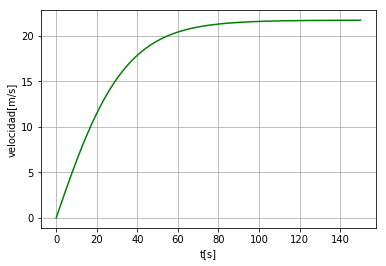

In [10]:
plt.plot(t, sol[:, 1], 'g')
plt.xlabel('t[s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

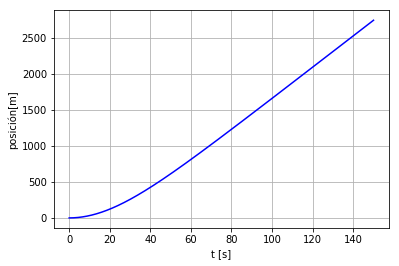

In [11]:
plt.plot(t, sol[:, 0], 'b')
plt.xlabel('t [s]')
plt.ylabel('posición[m]')
plt.grid()
plt.show()

Posteriormente, se desarrollo el modelo de frenado en el cual el torque se tomo como el máximo de frenado reportado por cordoba. En este modelo se usan las mismas funciones ya definidas, sin mebargo en este caso el torque de motor es constante (-20 Nm)

In [12]:
def dveldt_freno(velv,t0,torque,a):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    return [vel,(torque*a*ng*etaf/refc-frod-farr)/(masa+mr)] # para solucionar
    # al tiempo posición y velocidad

Las condiciones iniciales en este caso son 0 para la posición y la velocidad máxima alcanzada para la velocidad.

In [13]:
t_in_fren=0
t_fin_fren=7.2
deltat_fren=0.001

x_0=0.01
v_0_freno=sol[-1][1]
c_ini_freno = [x_0,v_0_freno]
t_freno=np.arange(t_in_fren,t_fin_fren,deltat_fren)

In [14]:
sol_freno = odeint(dveldt_freno, c_ini_freno, t_freno, args=(-20,1))

Se gráfico la velocidad y posición contra tiempo para el frenado hasta una velocidad de cero.

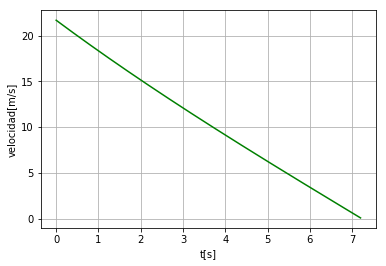

In [15]:
plt.plot(t_freno, sol_freno[:, 1], 'g')
plt.xlabel('t[s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

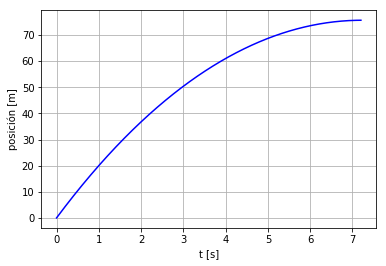

In [16]:
plt.plot(t_freno, sol_freno[:, 0], 'b', label='posición(t)')
plt.xlabel('t [s]')
plt.ylabel('posición [m]')
plt.grid()
plt.show()

Luego, se evaluo el desempeño en términos de velocidad máxima, aceleración de 0 a velocidad máxima, etc. en términos de los parámetros del kart, por ejemplo, masa, relación de transmisión, etc. 

- Relación de transmisión, en este caso todas las variables se mantienen constanstes y se cambia la relación de transmisión

In [17]:
sol_1= odeint(dveldt, c_ini, t,args=(1.8889,m))
sol_2= odeint(dveldt, c_ini, t,args=(2.1407,m))
sol_3= odeint(dveldt, c_ini, t,args=(2.3926,m))
sol_4= odeint(dveldt, c_ini, t,args=(2.6444,m))
sol_5= odeint(dveldt, c_ini, t,args=(2.8963,m))
sol_6= odeint(dveldt, c_ini, t,args=(3.1481,m))
sol_7= odeint(dveldt, c_ini, t,args=(3.4,m))
sol_8= odeint(dveldt, c_ini, t,args=(ng,m))

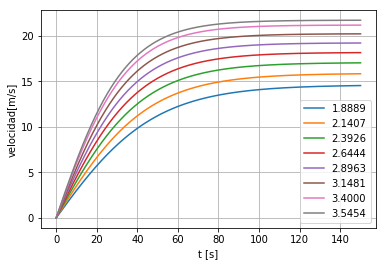

In [18]:
plt.plot(t, sol_1[:, 1],label='1.8889')
plt.plot(t, sol_2[:, 1],label='2.1407')
plt.plot(t, sol_3[:, 1],label='2.3926')
plt.plot(t, sol_4[:, 1],label='2.6444')
plt.plot(t, sol_5[:, 1],label='2.8963')
plt.plot(t, sol_6[:, 1],label='3.1481')
plt.plot(t, sol_7[:, 1],label='3.4000')
plt.plot(t, sol_8[:, 1],label='3.5454')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

En este caso se puede ver claramente que una relación de transmición más alta nos permitira lograr una velocidad máxima mayor, con respecto a la acelaración podemos ver una similitud entre los valores de realción de transmición usados.

* Masa, en este caso todas las variables se mantenienen constantes y se cambia la masa del kart

In [19]:
sol_1_m= odeint(dveldt, c_ini, t,args=(ng,60))
sol_2_m= odeint(dveldt, c_ini, t,args=(ng,80))
sol_3_m= odeint(dveldt, c_ini, t,args=(ng,100))
sol_4_m= odeint(dveldt, c_ini, t,args=(ng,120))
sol_5_m= odeint(dveldt, c_ini, t,args=(ng,140))
sol_6_m= odeint(dveldt, c_ini, t,args=(ng,m))
sol_7_m= odeint(dveldt, c_ini, t,args=(ng,180))
sol_8_m= odeint(dveldt, c_ini, t,args=(ng,200))

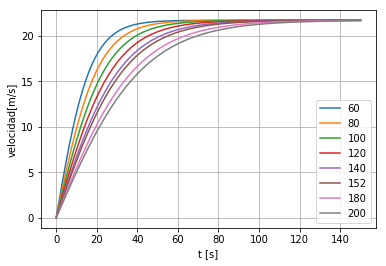

In [20]:
plt.plot(t, sol_1_m[:, 1],label='60')
plt.plot(t, sol_2_m[:, 1],label='80')
plt.plot(t, sol_3_m[:, 1],label='100')
plt.plot(t, sol_4_m[:, 1],label='120')
plt.plot(t, sol_5_m[:, 1],label='140')
plt.plot(t, sol_6_m[:, 1],label='152')
plt.plot(t, sol_7_m[:, 1],label='180')
plt.plot(t, sol_8_m[:, 1],label='200')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

En este caso la masa no afecta la velocidad máxima del kart, sin embargo si afecta la acelaración del kart, como se puede ver en la figura una masa del kart más pequeña permitira que acelere más rápido y enconsecuencia alcanzara la velcidad máxima en menor tiempo, mientras que un kart más pesado hara que la aceleración disminuya.

* Luego, se gráfica el desempeño de freno para diferentes relaciones de transmición

In [21]:
c_ini_freno_1 = [x_0,sol_1[-1][1]]
c_ini_freno_2 = [x_0,sol_2[-1][1]]
c_ini_freno_3 = [x_0,sol_3[-1][1]]
c_ini_freno_4 = [x_0,sol_4[-1][1]]
c_ini_freno_5 = [x_0,sol_5[-1][1]]
c_ini_freno_6 = [x_0,sol_6[-1][1]]
c_ini_freno_7 = [x_0,sol_7[-1][1]]
c_ini_freno_8 = [x_0,sol_8[-1][1]]
sol_freno_1 = odeint(dveldt_freno, c_ini_freno_1, np.arange(t_in_fren,5,deltat_fren), args=(-20,1))
sol_freno_2 = odeint(dveldt_freno, c_ini_freno_2, np.arange(t_in_fren,5.4,deltat_fren), args=(-20,1))
sol_freno_3 = odeint(dveldt_freno, c_ini_freno_3, np.arange(t_in_fren,5.8,deltat_fren), args=(-20,1))
sol_freno_4 = odeint(dveldt_freno, c_ini_freno_4, np.arange(t_in_fren,6.2,deltat_fren), args=(-20,1))
sol_freno_5 = odeint(dveldt_freno, c_ini_freno_5, np.arange(t_in_fren,6.5,deltat_fren), args=(-20,1))
sol_freno_6 = odeint(dveldt_freno, c_ini_freno_6, np.arange(t_in_fren,6.8,deltat_fren), args=(-20,1))
sol_freno_7 = odeint(dveldt_freno, c_ini_freno_7, np.arange(t_in_fren,7.1,deltat_fren), args=(-20,1))
sol_freno_8 = odeint(dveldt_freno, c_ini_freno_8, np.arange(t_in_fren,7.2,deltat_fren), args=(-20,1))

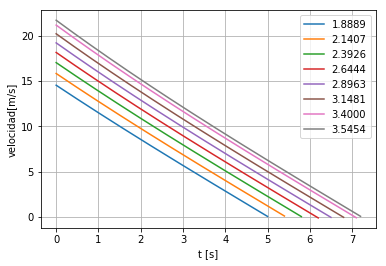

In [22]:
plt.plot(np.arange(t_in_fren,5,deltat_fren), sol_freno_1[:, 1],label='1.8889')
plt.plot(np.arange(t_in_fren,5.4,deltat_fren), sol_freno_2[:, 1],label='2.1407')
plt.plot(np.arange(t_in_fren,5.8,deltat_fren), sol_freno_3[:, 1],label='2.3926')
plt.plot(np.arange(t_in_fren,6.2,deltat_fren), sol_freno_4[:, 1],label='2.6444')
plt.plot(np.arange(t_in_fren,6.5,deltat_fren), sol_freno_5[:, 1],label='2.8963')
plt.plot(np.arange(t_in_fren,6.8,deltat_fren), sol_freno_6[:, 1],label='3.1481')
plt.plot(np.arange(t_in_fren,7.1,deltat_fren), sol_freno_7[:, 1],label='3.4000')
plt.plot(np.arange(t_in_fren,7.2,deltat_fren), sol_freno_8[:, 1],label='3.5454')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

El comportamiento es el esperado, ya que si la velocidad en la que se inicia el frenado es menor el tiempo de frenado tambien sera menor

* Torque de freno, en este caso la variable que se cambio fue la del torque de freno el cual es constante

In [23]:
c_ini_freno_11 = [x_0,sol[-1][1]]
c_ini_freno_21 = [x_0,sol[-1][1]]
c_ini_freno_31 = [x_0,sol[-1][1]]
c_ini_freno_41 = [x_0,sol[-1][1]]
c_ini_freno_51 = [x_0,sol[-1][1]]
c_ini_freno_61 = [x_0,sol[-1][1]]
c_ini_freno_71 = [x_0,sol[-1][1]]
c_ini_freno_81 = [x_0,sol[-1][1]]
sol_freno_1_t = odeint(dveldt_freno, c_ini_freno_11, np.arange(t_in_fren,20,deltat_fren), args=(-6,1))
sol_freno_2_t = odeint(dveldt_freno, c_ini_freno_21, np.arange(t_in_fren,16,deltat_fren), args=(-8,1))
sol_freno_3_t = odeint(dveldt_freno, c_ini_freno_31, np.arange(t_in_fren,13.3,deltat_fren), args=(-10,1))
sol_freno_4_t = odeint(dveldt_freno, c_ini_freno_41, np.arange(t_in_fren,11.4,deltat_fren), args=(-12,1))
sol_freno_5_t = odeint(dveldt_freno, c_ini_freno_51, np.arange(t_in_fren,10,deltat_fren), args=(-14,1))
sol_freno_6_t = odeint(dveldt_freno, c_ini_freno_61, np.arange(t_in_fren,8.8,deltat_fren), args=(-16,1))
sol_freno_7_t = odeint(dveldt_freno, c_ini_freno_71, np.arange(t_in_fren,8,deltat_fren), args=(-18,1))
sol_freno_8_t = odeint(dveldt_freno, c_ini_freno_81, np.arange(t_in_fren,7.2,deltat_fren), args=(-20,1))

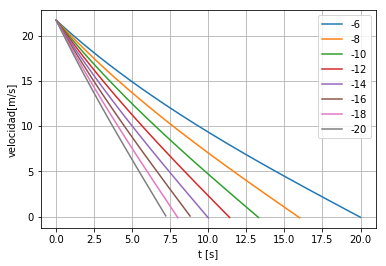

In [24]:
plt.plot(np.arange(t_in_fren,20,deltat_fren), sol_freno_1_t[:, 1],label='-6')
plt.plot(np.arange(t_in_fren,16,deltat_fren), sol_freno_2_t[:, 1],label='-8')
plt.plot(np.arange(t_in_fren,13.3,deltat_fren), sol_freno_3_t[:, 1],label='-10')
plt.plot(np.arange(t_in_fren,11.4,deltat_fren), sol_freno_4_t[:, 1],label='-12')
plt.plot(np.arange(t_in_fren,10,deltat_fren), sol_freno_5_t[:, 1],label='-14')
plt.plot(np.arange(t_in_fren,8.8,deltat_fren), sol_freno_6_t[:, 1],label='-16')
plt.plot(np.arange(t_in_fren,8,deltat_fren), sol_freno_7_t[:, 1],label='-18')
plt.plot(np.arange(t_in_fren,7.2,deltat_fren), sol_freno_8_t[:, 1],label='-20')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()

En este caso un torque mayor hace el kart llegue a velocidad cero en menos tiempo y cuando se aplica un torque menor el tiemo de frenado va a ser mayor, lo que concuerda con lo esperado

* Por ultimo, se realiza un modelo que permita estimar el tiempo y distancia recorrida en un proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero.

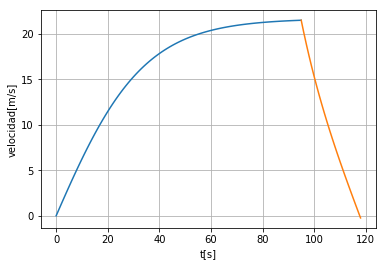

In [31]:
t_1=0
delta_t=1
v_0_f=0.01
x_0_f=0.01
tiempo=[]
velocidad=[]
posicion=[]
tiempo_1=[]
velocidad_1=[]
posicion_1=[]

for i in range(0,150):

    i=t_1+delta_t

    c_ini_f=[x_0_f,v_0_f]
    t_r=np.arange(t_1,i,0.0001)

    sol_f=odeint(dveldt, c_ini_f, t_r,args=(ng,m))

    vel=sol_f[:,1]
    dato_1=vel[-1]
    dato_2=vel[-2]

    resta=dato_1-dato_2

    velocidad.append(v_0_f)
    posicion.append(x_0_f)
    tiempo.append(t_1)

    v_0_f=sol_f[:,1][-1]
    x_0_f=sol_f[:,0][-1]
    t_1=i

    if resta < 1E-6:

        break

t_2=tiempo[-1]
v_0_f_1=velocidad[-1]
x_0_f_1=posicion[-1]

for y in range(t_2,120):

    y=t_2+delta_t
    c_ini_f_1=[x_0_f_1,v_0_f_1]
    t_r_1=np.arange(t_2,y,0.0001)

    sol_f_1=odeint(dveldt_freno, c_ini_f_1, t_r_1, args=(-5,1))

    vel=sol_f_1[:,1]
    dato_1=vel[0]

    velocidad_1.append(v_0_f_1)
    posicion_1.append(x_0_f_1)
    tiempo_1.append(t_2)

    v_0_f_1=sol_f_1[:,1][-1]
    x_0_f_1=sol_f_1[:,0][-1]
    t_2=y

    if dato_1 <= 0:

        break
    
plt.plot(tiempo,velocidad)
plt.plot(tiempo_1,velocidad_1)
plt.xlabel('t[s]')
plt.ylabel('velocidad[m/s]')
plt.grid()
plt.show()




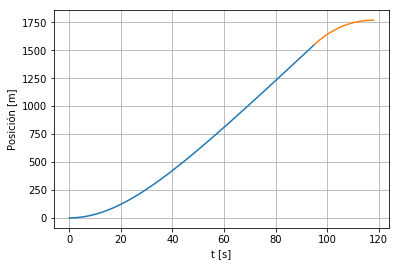

In [32]:
plt.plot(tiempo,posicion)
plt.plot(tiempo_1,posicion_1)
plt.xlabel('t [s]')
plt.ylabel('Posición [m]')
plt.grid()
plt.show()

In [33]:
tiempo_1[-1]

118

In [34]:
posicion_1[-1]

1768.4033094124466

In [35]:
velocidad[-1]

21.517606642412705

Los resultados obtenidos para un torque de freno de -5 Nm son:

Distancia recorrida: 1768.40 [m]

Tiempo total: 118 [s]

Velocidad máxima: 21.52 [m/s]